In [1]:
# Install Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-a77fa5ql
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-a77fa5ql
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


In [2]:
# Import necessary libraries
import os
import torch
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo
from detectron2.config import get_cfg
import detectron2.utils.comm as comm

In [3]:
# Check if GPU is available
assert torch.cuda.is_available(), "CUDA is not available. Please enable a GPU Runtime in Kaggle."

In [4]:
# Dataset paths
dataset_path = '/kaggle/input/yolov10-cube-failure-coco-dataset/'
train_json = os.path.join(dataset_path, 'train/_annotations.coco.json')
val_json = os.path.join(dataset_path, 'valid/_annotations.coco.json')
train_images = os.path.join(dataset_path, 'train')
val_images = os.path.join(dataset_path, 'valid')

In [5]:
# Register the dataset in COCO format
register_coco_instances("cube_train", {}, train_json, train_images)
register_coco_instances("cube_val", {}, val_json, val_images)

In [6]:
# Metadata for visualization
cube_metadata = MetadataCatalog.get("cube_train")

In [7]:
# Custom Hook for Loss Evaluation and Logging
class LossEvalHook(HookBase):
    def __init__(self, cfg, model, data_loader):
        self.cfg = cfg.clone()
        self.model = model
        self.data_loader = data_loader

    def after_epoch(self):
        # Run evaluation on the validation set
        evaluator = COCOEvaluator("cube_val", self.cfg, False, output_dir="./output/")
        val_loader = build_detection_test_loader(self.cfg, "cube_val")
        results = inference_on_dataset(self.model, val_loader, evaluator)
        
        # Access the AP, losses, and confidence
        AP50 = results['bbox']['AP50']
        total_loss = self.trainer.storage.latest()['total_loss']
        
        # Log the metrics
        print(f"Epoch {self.trainer.iter // self.trainer.storage.cfg.SOLVER.MAX_ITER + 1} - Loss: {total_loss:.4f}, AP50: {AP50:.4f}")
# Custom Trainer to Include LossEvalHook
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, True, output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(self.cfg, self.model, build_detection_test_loader(self.cfg, "cube_val")))
        return hooks

In [10]:
# Model configuration for RetinaNet
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cube_train",)
cfg.DATASETS.TEST = ("cube_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Number of classes (just one: "cube")
cfg.MODEL.RETINANET.NUM_CLASSES = 1  # This line sets the correct number of classes for RetinaNet

# Pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # Adjust learning rate
cfg.SOLVER.MAX_ITER = 1000  # Adjust the number of iterations
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # Adjust threshold for RetinaNet

# Output directory for the model
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create a custom trainer instance
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [11]:
# Evaluation after training
evaluator = COCOEvaluator("cube_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "cube_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APs': nan,
               'APm': nan,
               'APl': nan})])

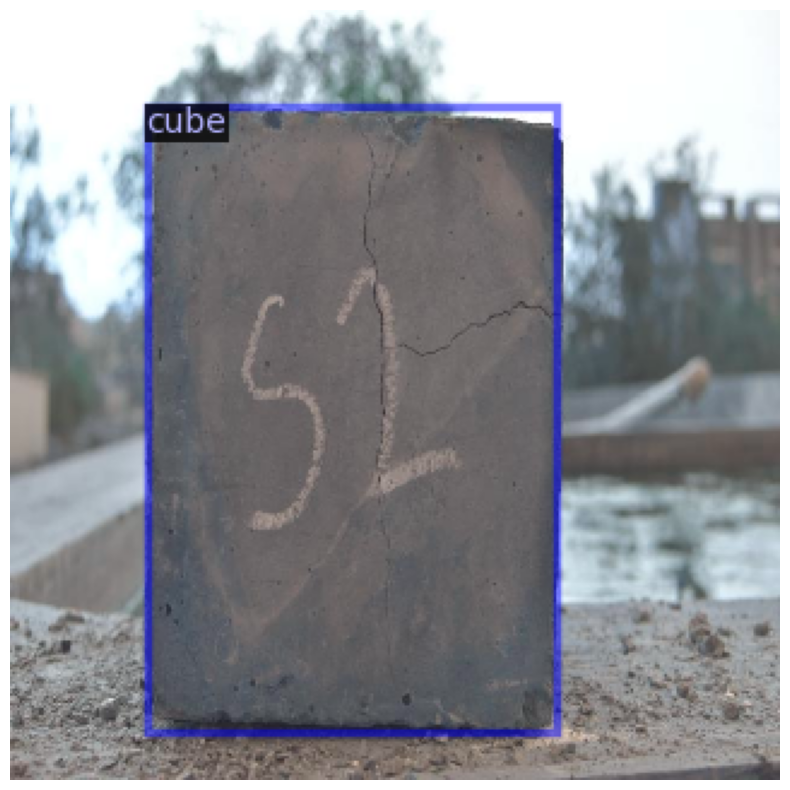

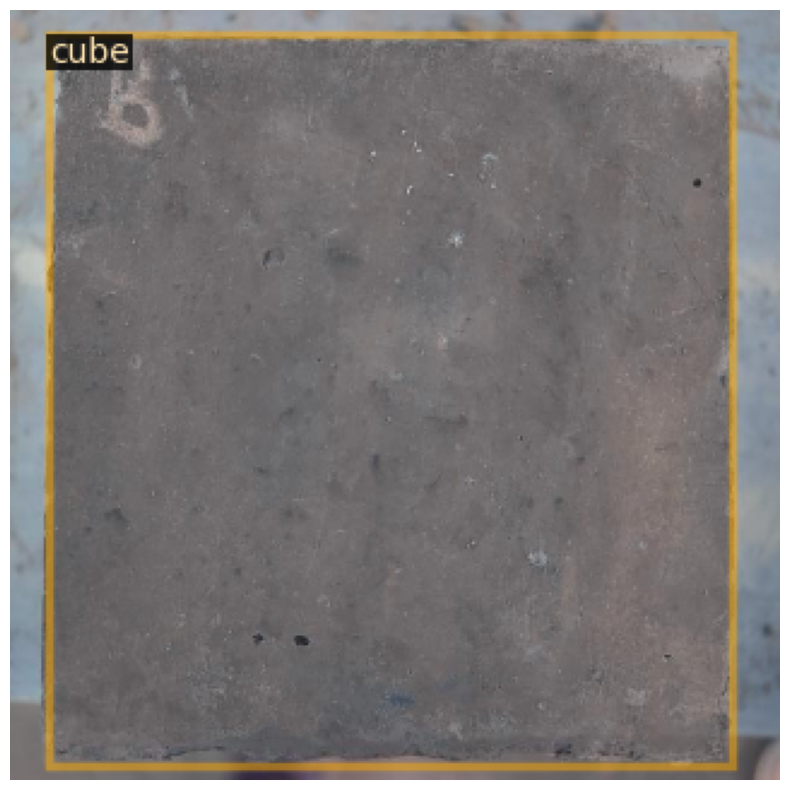

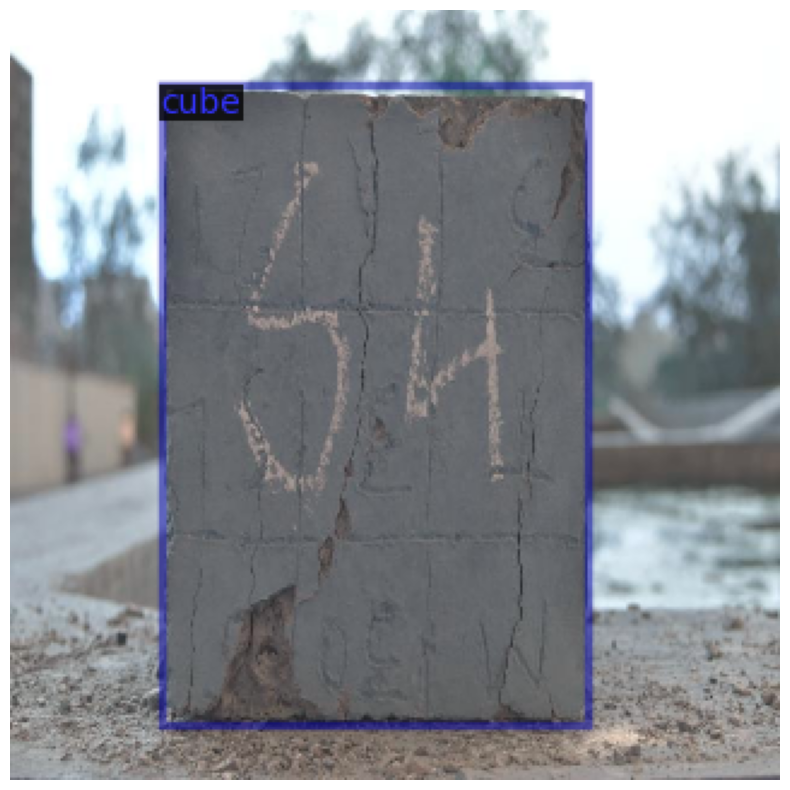

In [12]:
# Visualize Random Samples from Validation Set
dataset_dicts = DatasetCatalog.get("cube_val")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cube_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    vis = visualizer.draw_dataset_dict(d)
    vis_img_rgb = vis.get_image()[:, :, ::-1]
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img_rgb)
    plt.axis('off')
    plt.show()